## 1. Introduction and cleaning of Data set <a name="introduction"></a>

Before starting on the project, I first need to gain information regarding the Data provided and clean up the Data.

### 1.1 Importing Neccesary Libraries and Reading Data Files

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import mplleaflet 
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from bokeh.palettes import brewer
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import LabelSet, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.tile_providers import CARTODBPOSITRON
%matplotlib inline

In [2]:
firm_size = pd.read_csv('./data/base_etablissement_par_tranche_effectif.csv')
geo = pd.read_csv('./data/name_geographic_information.csv')
salary = pd.read_csv('./data/net_salary_per_town_categories.csv')

### 1.2 Cleaning up dataframes
#### 1.2.1 Geographical Dataframe

First, we gain insights by looking at the basic information of the dataframe 

In [3]:
geo.head()

,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
0,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Attignat,01340,1024,46.283333,5.166667,1.21
1,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Beaupont,01270,1029,46.400000,5.266667,1.91
2,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bény,01370,1038,46.333333,5.283333,1.51
3,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Béreyziat,01340,1040,46.366667,5.05,1.71
4,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bohas-Meyriat-Rignat,01250,1245,46.133333,5.4,1.01


In [4]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36840 entries, 0 to 36839
Data columns (total 14 columns):
EU_circo                  36840 non-null object
code_région               36840 non-null int64
nom_région                36840 non-null object
chef.lieu_région          36840 non-null object
numéro_département        36840 non-null object
nom_département           36840 non-null object
préfecture                36840 non-null object
numéro_circonscription    36840 non-null int64
nom_commune               36840 non-null object
codes_postaux             36840 non-null object
code_insee                36840 non-null int64
latitude                  33911 non-null float64
longitude                 33999 non-null object
éloignement               33878 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 3.9+ MB


#### Dropping unneccesary columns

For this Dataset, I only require the name of the regions associated with the GEO number, as well as the Long and Lat columns. Hence, I will drop all columns not related to these columns.

I will then go on to rename the columns in French to English so that I may better access to dataframe

In [5]:
#dropping unncessary columns
geo.drop(['EU_circo', 'code_région', 'éloignement', 'numéro_département', 'nom_département', 'préfecture', 'numéro_circonscription', 'codes_postaux'], axis=1, inplace=True)

In [6]:
#renaming columns to english
geo.rename(columns={
    'nom_région' : 'region_name',
    'nom_commune' : 'town_name',
    'code_insee' : 'unique_geo_code',
    'codes_postaux' : 'postal_codes',
    'chef.lieu_région' : 'city'
}, inplace = True)

Here, we replace all commas with dots so that strings can be succesfully converted to float values when converted. We also ignore all NaN values.

Then, we drop all duplicate rows

In [7]:
geo['longitude'] = geo['longitude'].str.replace(',','.')
geo['longitude'] = pd.to_numeric(geo['longitude'], errors = 'coerce')
geo = geo.dropna()
geo.drop_duplicates(subset = 'unique_geo_code', keep = 'first', inplace = True)
#check that there are no missing (NaN) values
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33706 entries, 0 to 36707
Data columns (total 6 columns):
region_name        33706 non-null object
city               33706 non-null object
town_name          33706 non-null object
unique_geo_code    33706 non-null int64
latitude           33706 non-null float64
longitude          33706 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.8+ MB


### 1.2.2 Salary Dataframe

In [8]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5136 entries, 0 to 5135
Data columns (total 26 columns):
CODGEO       5136 non-null object
LIBGEO       5136 non-null object
SNHM14       5136 non-null float64
SNHMC14      5136 non-null float64
SNHMP14      5136 non-null float64
SNHME14      5136 non-null float64
SNHMO14      5136 non-null float64
SNHMF14      5136 non-null float64
SNHMFC14     5136 non-null float64
SNHMFP14     5136 non-null float64
SNHMFE14     5136 non-null float64
SNHMFO14     5136 non-null float64
SNHMH14      5136 non-null float64
SNHMHC14     5136 non-null float64
SNHMHP14     5136 non-null float64
SNHMHE14     5136 non-null float64
SNHMHO14     5136 non-null float64
SNHM1814     5136 non-null float64
SNHM2614     5136 non-null float64
SNHM5014     5136 non-null float64
SNHMF1814    5136 non-null float64
SNHMF2614    5136 non-null float64
SNHMF5014    5136 non-null float64
SNHMH1814    5136 non-null float64
SNHMH2614    5136 non-null float64
SNHMH5014    5136 no

In [9]:
salary.tail()

,CODGEO,LIBGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
5131,97420,Sainte-Suzanne,12.9,24.5,15.4,10.9,10.9,12.4,21.6,14.7,...,11.1,9.2,12.8,15.4,9.3,12.3,14.7,9.2,13.1,15.8
5132,97421,Salazie,10.4,17.3,13.8,9.6,9.8,9.8,13.2,11.4,...,10.0,9.0,10.6,11.4,8.9,9.9,10.5,9.0,11.0,11.7
5133,97422,Le Tampon,12.0,23.3,14.7,10.3,10.5,11.5,21.3,14.1,...,10.6,8.9,11.9,14.9,8.9,11.4,13.9,9.0,12.1,15.4
5134,97423,Les Trois-Bassins,11.4,22.6,13.4,10.1,10.5,10.8,15.9,12.4,...,10.5,8.9,11.5,13.1,8.9,11.1,11.4,9.0,11.8,13.7
5135,97424,Cilaos,10.4,21.0,13.3,8.9,10.2,9.8,18.3,13.0,...,10.3,8.9,10.2,12.6,9.0,9.5,11.8,8.9,10.4,12.9


### Converting CODGEO salary data from object (string type) to int64 using a boolean mask

In [10]:
salary = salary[salary['CODGEO'].apply(lambda x : str(x).isdigit())]
salary['CODGEO'] = salary['CODGEO'].astype(dtype = 'int64')

### 1.3.3 Firm Dataset

Creating Bins for the Data Sets accroding to https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Enterprise_size

<u> The Classifications Are: </u><br/>
Micro Frims < 10 <br/>
Small < 50, <br/>
SME < 250, <br/>
Large >= 250 <br/>

In [11]:
#firm dataset
#converting CODGEO to int64
firm_size = firm_size[firm_size['CODGEO'].apply(lambda x : str(x).isdigit())]
firm_size['CODGEO'] = firm_size['CODGEO'].astype(dtype = 'int64')

firm_size['micro'] = firm_size['E14TS1'] + firm_size['E14TS6']
firm_size['small'] = firm_size['E14TS10'] + firm_size['E14TS20']
firm_size['sme'] = firm_size['E14TS50'] + firm_size['E14TS100']
firm_size['large'] = firm_size['E14TS200'] + firm_size['E14TS500']

firm_size['total'] = firm_size['E14TS1'] + firm_size['E14TS6'] + firm_size['E14TS10'] + firm_size['E14TS20'] + firm_size['E14TS50'] + firm_size['E14TS100'] + firm_size['E14TS200'] + firm_size['E14TS500']

firm_size['micro%'] = firm_size.micro/firm_size.total
firm_size['small%'] = firm_size.small/firm_size.total
firm_size['sme%'] = firm_size.sme/firm_size.total
firm_size['large%'] = firm_size.large/firm_size.total

In [12]:
#including only neccesary columns for firmsize
firm_size = firm_size[['CODGEO', 'LIBGEO', 'REG', 'DEP','micro','small','sme','large','total','micro%','small%','sme%','large%']]

### 1.4 Merging all data sides by CODGEO

In [13]:
#merging data sets
all_data = pd.merge(firm_size, geo, how = 'left', left_on = "CODGEO", right_on = "unique_geo_code")

In [14]:
all_data.info()
all_data.drop_duplicates(subset = 'unique_geo_code', keep = 'first', inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36321 entries, 0 to 36320
Data columns (total 19 columns):
CODGEO             36321 non-null int64
LIBGEO             36321 non-null object
REG                36321 non-null int64
DEP                36321 non-null object
micro              36321 non-null int64
small              36321 non-null int64
sme                36321 non-null int64
large              36321 non-null int64
total              36321 non-null int64
micro%             31310 non-null float64
small%             31310 non-null float64
sme%               31310 non-null float64
large%             31310 non-null float64
region_name        33372 non-null object
city               33372 non-null object
town_name          33372 non-null object
unique_geo_code    33372 non-null float64
latitude           33372 non-null float64
longitude          33372 non-null float64
dtypes: float64(7), int64(7), object(5)
memory usage: 5.5+ MB


In [15]:
all_data.head()

,CODGEO,LIBGEO,REG,DEP,micro,small,sme,large,total,micro%,small%,sme%,large%,region_name,city,town_name,unique_geo_code,latitude,longitude
0,1001,L'Abergement-Clémenciat,82,01,3,0,0,0,3,1.000000,0.000000,0.00000,0.000000,Rhône-Alpes,Lyon,L'Abergement-Clémenciat,1001.0,46.15,4.916667
1,1002,L'Abergement-de-Varey,82,01,1,0,0,0,1,1.000000,0.000000,0.00000,0.000000,Rhône-Alpes,Lyon,L'Abergement-de-Varey,1002.0,46.00,5.416667
2,1004,Ambérieu-en-Bugey,82,01,335,70,12,2,419,0.799523,0.167064,0.02864,0.004773,Rhône-Alpes,Lyon,Ambérieu-en-Bugey,1004.0,45.95,5.350000
3,1005,Ambérieux-en-Dombes,82,01,23,3,0,0,26,0.884615,0.115385,0.00000,0.000000,Rhône-Alpes,Lyon,Ambérieux-en-Dombes,1005.0,46.00,4.900000
4,1006,Ambléon,82,01,0,0,0,0,0,NaN,NaN,NaN,NaN,Rhône-Alpes,Lyon,Ambléon,1006.0,45.75,5.600000


## 2 Plotting firms on the map of Paris

First, we create a helper function to convert latitude and longitude values to mercator values in order to plot them using bokeh. (The bokeh values plots by mercator values).

In [16]:
#helper function to convert lat and long to merc values so that it can be plotted on bokeh
import math
from ast import literal_eval
def merc(lat,lon):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [17]:
#convert lat,long values to mercator values.
all_data['x_coords'] = all_data.apply(lambda x : merc(x['latitude'], x['longitude'])[0], axis =1)
all_data['y_coords'] = all_data.apply(lambda x : merc(x['latitude'], x['longitude'])[1], axis =1)

### 2.1 Extracting top 10 cities for better visualization on the map

Next, we extract the top 10 cities by industry size so that we can indentify the top 10 cities with the biggest industries in France.

In [18]:
#extracting top 10 city by industry size
top10 = all_data.sort_values(by=['total'], ascending=False)[:10]
top10['x_coords'] = top10.apply(lambda x : merc(x['latitude'], x['longitude'])[0], axis =1)
top10['y_coords'] = top10.apply(lambda x : merc(x['latitude'], x['longitude'])[1], axis =1)


In [19]:
#getting paris map
p = figure(x_range=(300000, 600000), y_range=(5001937.627028765, 6851937.627028765),
           x_axis_type="mercator", y_axis_type="mercator",
          width = 800, height = 600, 
           title = "France Industry as a Whole")

p.add_tile(CARTODBPOSITRON)

#determine circle size when plotting on map
all_data['c_size'] = all_data['total'] / 950

#plotting circle points on the map
p.circle(x = all_data['x_coords'],
         y = all_data['y_coords'],
         size = all_data['c_size'],
        fill_alpha = 0.3)

#adding top10 city industry size labels to map

p.circle(x = top10['x_coords'],
         y = top10['y_coords'],
        size = 3,
        color = 'black')

labels = LabelSet( x = 'x_coords', y = 'y_coords', text = 'city', level = 'glyph', x_offset = 5, y_offset = 5, 
                  source = ColumnDataSource(top10), render_mode = 'canvas')
output_notebook()
p.add_layout(labels)
p.axis.visible = False
show(p)

Loading BokehJS ...

From this visualization, we can see the top 10 cities with the biggest total number of firms. 

The circle size corresponds to the total amount of firms in the city.

In addition, we can see how much bigger the circle for Paris is to the rest of the cities. Hence, we can conclude that Paris is the main driver of the economic force in France due to its dense population of firms.

### 2.3 Seeing the makeup of type of firms and the total number of firms for the Top 10 Cities

In [24]:
#distribtuion of company type per country
top10 = top10.sort_values(by=["total"], ascending = False).head(10)
top10 = top10.reset_index()

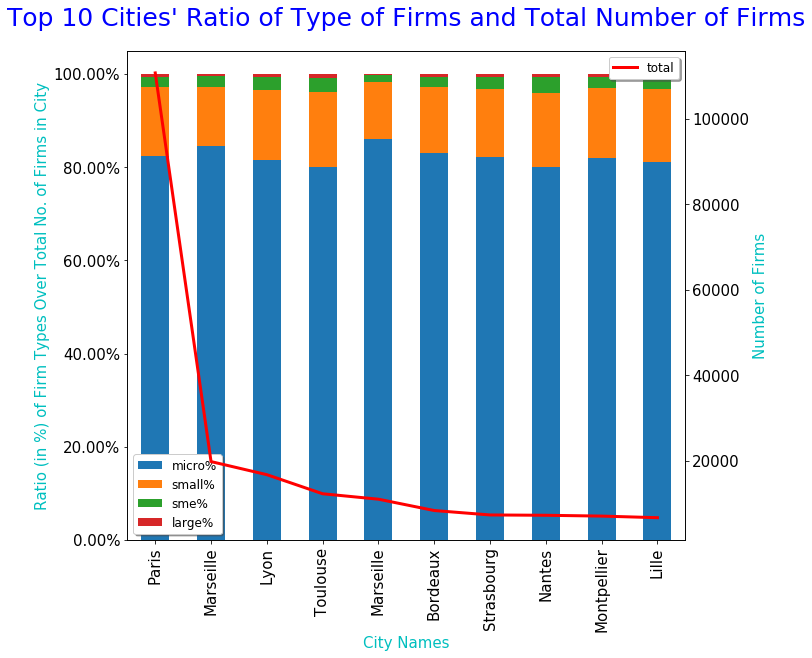

In [25]:
ax1 = top10.loc[:, ['city','micro%','small%','sme%','large%']].plot(kind='bar', stacked = True, figsize = (10,9))

plt.title("Top 10 Cities' Ratio of Type of Firms and Total Number of Firms", fontsize = 25, fontweight = 'light', pad = 25
         , color = 'b')

ax1.set_xticklabels([x for x in top10.city], fontsize = 15)

ax1.set_xlabel("City Names", fontsize = 15, color = 'c')

ax1.set_ylabel("Ratio (in %) of Firm Types Over Total No. of Firms in City", fontsize = 15, color = 'c')

vals = ax1.get_yticks()

ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals], fontsize = 15)

plt.legend(loc = 'best', fontsize = 'large',  frameon = True, shadow = True)

ax2 = ax1.twinx()

ax2.plot(top10.total, color = 'red', linewidth = 3)

ax2.set_ylabel("Number of Firms", fontsize = 15, color = 'c')

plt.legend(loc = 'best', fontsize = 'large', frameon = True, shadow = True)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

Here, we can see that the firms in most cities are made up of micro firms (< 10 employees) 

Additionally, Paris has a drastically high number of firms (reaching amounts of >10,000) as compared to the rest of the cities.

## 3. Examining the Wage Difference between Men and Women

First, we create an x-label for the different positions available.

Then, we calculate the mean salaries of women and men for each position.

We also calculate the salary difference in percentage in order to see the difference of salaries from women and men for each category clearly.

In [22]:
#displaying the wage-difference

positions = ["Executive", "Middle Manager", "Employee", "Worker"]

avg_w_salary = salary[["SNHMFC14", "SNHMFP14", "SNHMFE14", "SNHMFO14"]].mean()

avg_m_salary = salary[["SNHMHC14", "SNHMHP14", "SNHMHE14", "SNHMHO14"]].mean()

#calcuate difference of salary in percentage values

salary_difference = []

for w,m in zip(avg_w_salary,avg_m_salary):
    salary_difference.append(round(abs(w-m)/m, 2))


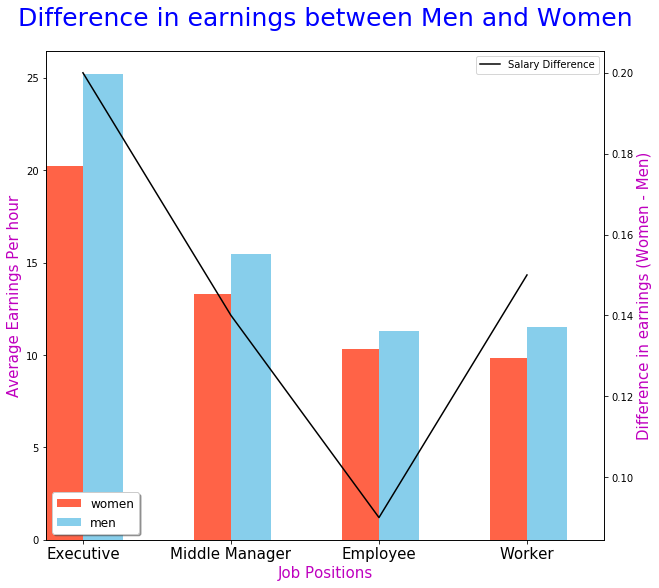

In [23]:
#plotting women-men salary difference

ax1 = avg_w_salary.plot(kind ='bar', color = 'tomato', figsize = (10,9), label = 'women')
ax1 = avg_m_salary.plot(kind='bar', width = 0.27, align = 'edge', color = 'skyblue', label = 'men')

ax1.set_xticklabels(positions, fontsize = 15, rotation = 0)
ax1.set_xlabel("Job Positions", fontsize = 15, color = "m")
ax1.set_ylabel("Average Earnings Per hour", fontsize = 15, color = "m")

ax1.legend(loc = 3,fontsize = 'large',  frameon = True, shadow = True)
ax2 = ax1.twinx()
ax2.plot(salary_difference, color = 'black', label = 'Salary Difference')

ax2.set_ylabel("Difference in earnings (Women - Men)", fontsize = 15, color = "m")

plt.legend()

plt.title("Difference in earnings between Men and Women", fontsize = 25, fontweight = 'light', pad = 25
         , color = 'b')

plt.show()

Here, we see that the men earn more than women accross all positions and the difference in salaries are highest at the Executive job positions and lowest at the Employee job position.